# Action 1

In [1]:
import pandas as pd

## 数据加载

In [2]:
pm_data = pd.read_csv('pollution.csv', index_col=0) #在进行数据探索之后，使用date来作为index

## 数据探索与清理

In [3]:
pm_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
#查看每列的类型
pm_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [5]:
#检查是否有空值
pm_data.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

## 可视化

In [7]:
import matplotlib.pyplot as plt

In [8]:
values = pm_data.values

In [9]:
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [10]:
#一共有八个特征
groups = [i for i in range(8)]

In [11]:
groups

[0, 1, 2, 3, 4, 5, 6, 7]

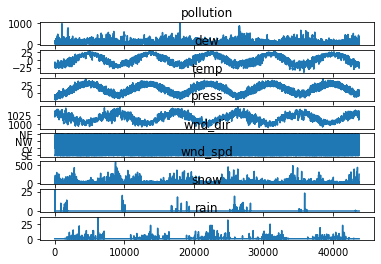

In [12]:
#画出几个特征的走势图
for i in groups:
    plt.subplot(8,1,i+1) #一共八个子图，排成一列
    plt.plot(values[:,i]) #画出第i个特征的图, 从第二个开始画，因为第一个是时间
    plt.title(pm_data.columns[i])
plt.show()


In [13]:
pm_data['wnd_dir'].value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [14]:
# 将分类特征wnd_dir进行标签编码
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform (values[:,4])

# 设置数据类型为float32
values = values.astype('float32')

In [15]:
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

## 数据规范化

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)
scaled_data.shape

(43800, 8)

## 将时间序列数据转换为适用于监督学习的数据

In [22]:
#这个方法可以把时间序列的数据转化为特征标签类的数据，标签（y），就是下个时刻的PM2.5值

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [24]:
# 将时间序列数据转化为适合监督学习的数据
reframed_data = series_to_supervised(scaled_data,1,1)
reframed_data.to_csv('reframed-data.csv')

#从下表可以看到，带有（t-1）的是之前的数据，也就是需要拿来预测的特征值，之后的（t）则是需要预测的标签
#其中，我们只需要预测PM2.5值，所以去掉var2（t)之后的列
reframed_data

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [25]:
# 去掉不需要的列
reframed_data.drop(reframed_data.columns[[9,10,11,12,13,14,15]], axis = 1, inplace=True)
reframed_data.to_csv('final_reframed_data.csv')
reframed_data

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


## 建立模型来训练

In [26]:
#数据集切分， 二比八
#LSTM 不能采用train_test_split(), 因为时间序列不连续
#XGBoost 可以，因为样本互相独立

values = reframed_data.values
n_train_hours = int(len(values) * 0.8)
#获取前80%行数据作为训练集
train_data = values[:n_train_hours,:]

In [27]:
#获取后20%行数据作为测试集
test_data = values[n_train_hours:,:]

#### 拆分特征和标签

In [30]:
train_x, train_y = train_data[:,:-1], train_data[:,-1]
test_x, test_y = test_data[:,:-1], test_data[:,-1]

In [31]:
train_x.shape

(35039, 8)

In [32]:
train_y.shape

(35039,)

In [33]:
# 为了LSTM，转化成3d格式[样本数，时间步，特征数]
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

In [35]:
train_x.shape

(35039, 1, 8)

In [36]:
from tensorflow.keras.models import Sequential

In [38]:
from tensorflow.keras.layers import Dense, LSTM

#### 设置模型

In [56]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse') #回归值使用mse作为loss


#### 模型训练

In [57]:
result = model.fit(train_x,train_y, epochs=10, batch_size=64, validation_data=(test_x,test_y), verbose = 2, shuffle=False)

Train on 35039 samples, validate on 8760 samples
Epoch 1/10
35039/35039 - 3s - loss: 0.0027 - val_loss: 0.0055
Epoch 2/10
35039/35039 - 2s - loss: 8.3412e-04 - val_loss: 0.0018
Epoch 3/10
35039/35039 - 2s - loss: 8.0043e-04 - val_loss: 0.0014
Epoch 4/10
35039/35039 - 2s - loss: 8.0164e-04 - val_loss: 0.0011
Epoch 5/10
35039/35039 - 2s - loss: 8.0423e-04 - val_loss: 0.0010
Epoch 6/10
35039/35039 - 2s - loss: 8.0447e-04 - val_loss: 9.8621e-04
Epoch 7/10
35039/35039 - 2s - loss: 8.0438e-04 - val_loss: 9.6423e-04
Epoch 8/10
35039/35039 - 2s - loss: 8.0432e-04 - val_loss: 9.5713e-04
Epoch 9/10
35039/35039 - 2s - loss: 8.0415e-04 - val_loss: 9.6081e-04
Epoch 10/10
35039/35039 - 2s - loss: 8.0388e-04 - val_loss: 9.7223e-04


#### 模型预测

In [58]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
test_predict

array([[0.02684353],
       [0.02770949],
       [0.05358775],
       ...,
       [0.01290924],
       [0.01289771],
       [0.01120806]], dtype=float32)

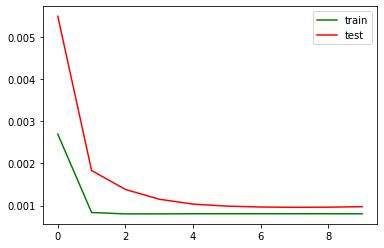

In [59]:
#绘制训练损失和测试损失

line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc = 'best')
plt.show()


In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


## 可视化呈现结果

In [64]:
from matplotlib import font_manager

In [65]:
#fname 字体文件 
#因为图表中使用了中文，所以需要加载中文字体文件
my_font = font_manager.FontProperties(fname='C:/Windows/Fonts/SIMLI.TTF',size=18)

In [82]:
def plot_img(source, train_predict, test_predict):
    plt.figure(figsize=(20,8),dpi=80)
    #原始数据
    plt.plot(source[:,-1], label='原始数据', c='b')
    #训练数据
    plt.plot([x for x in train_predict], label = '训练集预测值', c= 'g')
    #预测结果
    plt.plot([None for _ in train_predict]+[x for x in test_predict], label = '测试集预测值', c ='r')
    # 设置标题
    plt.title('绘制对比图',fontproperties=my_font,color='red')
    #rotation将字体旋转45度
    plt.xlabel('时间',fontproperties=my_font,rotation=45)
    plt.ylabel("pm2.5值",fontproperties=my_font)
    
    plt.legend(prop=my_font,loc='best')
    plt.show()

In [83]:
#绘制原始数据，训练和预测值的对比图

C:\Users\guoxi\anaconda3\envs\python36\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


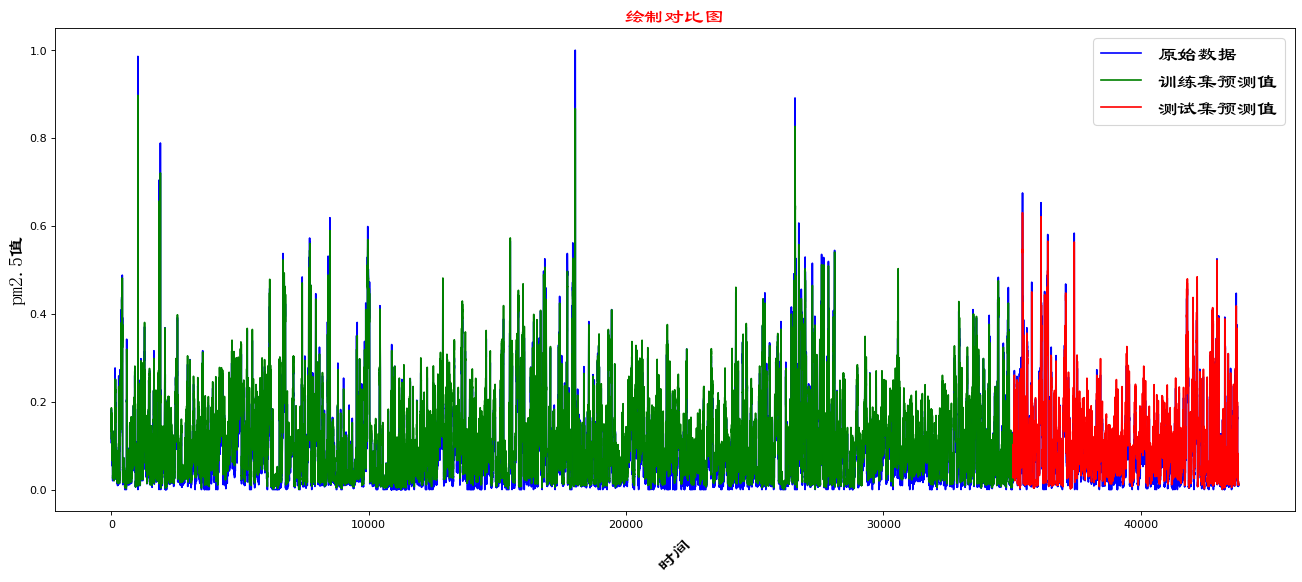

In [84]:
plot_img(values,train_predict,test_predict)